Let's do 3+1 dimensions, consider $x^\mu \in \mathbb{R}^{1+3}$, where $f$ is the Fourier transform of a Gaussian:

\begin{align}
  [\phi(x), \phi(0)] = \int_{-\infty}^\infty \frac{\mathrm d^3p}{(2\pi)^3} \frac{f^2(|\vec p|)}{2 F_{\vec p}} \left( e^{-ip_\mu x^\mu} - e^{ip_\mu x^\mu}\right) \bigg\rvert_{p^0 = F_{\vec p}} \\
\end{align}

Choose spherical coordinates $\vec p = (r, \theta, \phi)$ with $\hat z$ direction along $\vec x$. Now let $t = x^0$ and $x = |\vec x|$. The integral simplifies to:

\begin{align}
  [\phi(x), \phi(0)] = -i \int_{0}^\infty \frac{\mathrm dr}{2\pi^2} t r^2 \, \mathrm{sinc}(rx) \, f^2(r^2) \, \mathrm{sinc}(t E_r f(r^2))
\end{align}

Rescale $r \mapsto r' = r/\sigma$ and instead of plotting a $t$ vs. $x$ diagram, plot the dimensionless quantities $t' = mt$ vs. $x' = mx$. Then the only (dimensionful) parameter of this commutator is $\alpha = \sigma m$ with units of energy, up to an overall factor of $\sigma^{-2}$.

\begin{align}
  \left| [\phi(x), \phi(0)] \right| &= \frac{1}{\sigma^2} \cdot \frac{t'}{2\pi^2 \alpha} \int_0^\infty \mathrm dr \, r^2 \, e^{-\frac12 r^2} \, \mathrm{sinc}\left(\frac{rx'}{\alpha}\right) \, \mathrm{sinc}\left(t' \sqrt{\frac{r^2}{\alpha^2} + 1}\right)
\end{align}

In [6]:
NUM_PROC = 56
FOLDER = "./output/"

from IPython.utils import io
import numpy as np
import multiprocessing as mp

In [8]:
%%writefile temp.py

import numpy as np
import scipy.integrate as integrate
import warnings

def integrand(r, x, t, a):
    return r**2 * np.exp(-1/2 * r**2) * np.sinc(r*x/a) * np.sinc(t * np.sqrt(r**2/a**2 + 1))
    
def comm(x, t, a):
    with warnings.catch_warnings():
   # with warnings.catch_warnings(action='ignore', category=integrate.IntegrationWarning):
        warnings.simplefilter("ignore")
        I = integrate.quad(integrand, 0, +np.inf, args=(x, t, a))[0]    
    
    return abs(1/(2 * np.pi**2 * a) * t * I)**2

Overwriting temp.py


In [9]:
from temp import comm

def calc(lim_x, lim_t, step, alpha):
    xs = np.linspace(-lim_x, lim_x, step)
    ts = np.linspace(-lim_t, lim_t, step)
    
    xx, tt = np.meshgrid(xs, ts)
    arguments = [(x, t, alpha) for t in ts for x in xs]

    mp_context = mp.get_context("spawn")
    with mp_context.Pool(processes=NUM_PROC) as pool:
        #with io.capture_output():
        z = pool.starmap(comm, arguments)

    z = np.array(z).reshape(step, step)
    return xx, tt, z

In [39]:
import matplotlib.pyplot as plt

def plot(xx, tt, z, sigma, mass, label=None, log=False):
    ax = plt.gca()
    ax.axis('equal')
    ax.set_box_aspect(1)
    
    cnt = plt.pcolormesh(xx, tt, z, cmap='viridis', antialiased=False, shading='auto')
    
    plt.colorbar()
    plt.xlabel("Space Coordinate $m x$")
    plt.ylabel("Time Coordinate $m t$")
    plt.title("$" + (r"\log" if log else "") + "|\sigma^2 [\phi(mt,0,0,mx), \phi(0,0,0,0)]|^2$, "
                  + f"$\sigma = {sigma}, m = {mass}$")
    
    if label:
        plt.savefig(FOLDER + label + ("-log" if log else "") + ".png")
    
    plt.show()
    
def run1(lim_x, lim_t, step, sigma, mass, label=None, log=False):
    alpha = sigma * mass
    
    xx, tt, z = calc(lim_x, lim_t, step, alpha)
    
    if not label:
        label = f"numerical-commutator-m{mass}-s{sigma}-l{lim_x}-{lim_t}"
    
    plot(xx, tt, z, sigma, mass, label=label, log=False)
    
    if log:
        plot(xx, tt, np.log(z), sigma, mass, label=label, log=True)

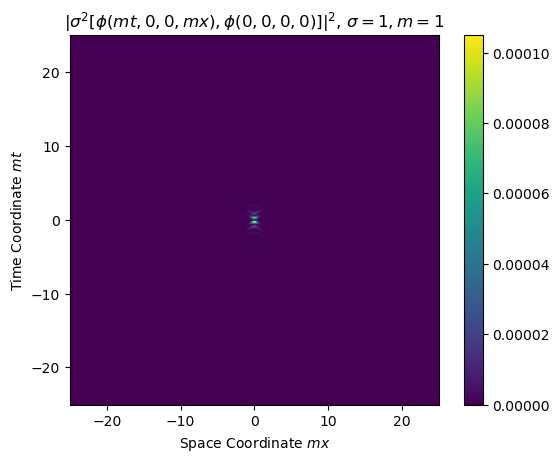

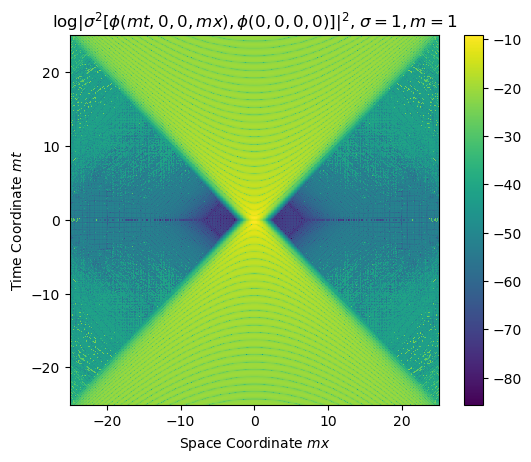

In [40]:
#run1(a, b, num_bins, \sigma, m)
run1(25, 25, 500, 1, 1, log=True)

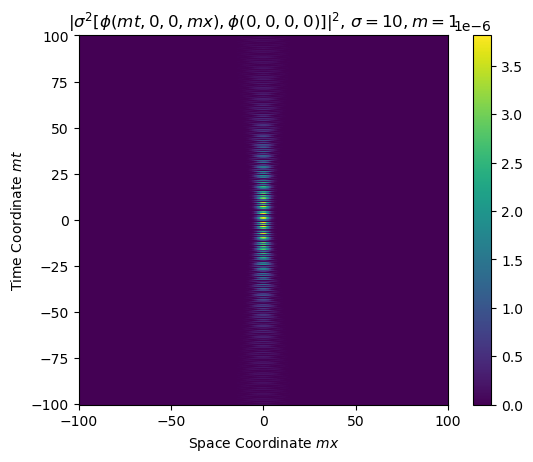

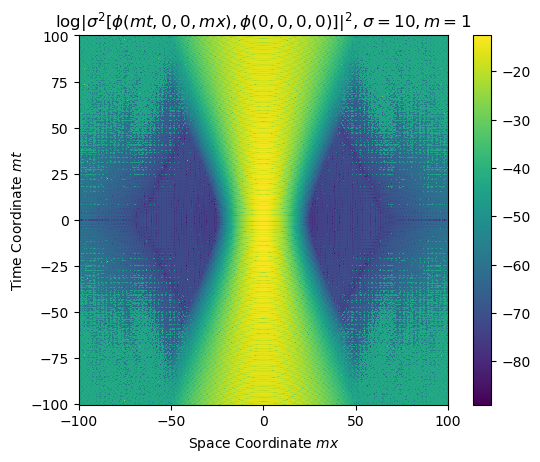

In [41]:
#run1(a, b, num_bins, \sigma, m)
run1(100, 100, 500, 10, 1, log=True)

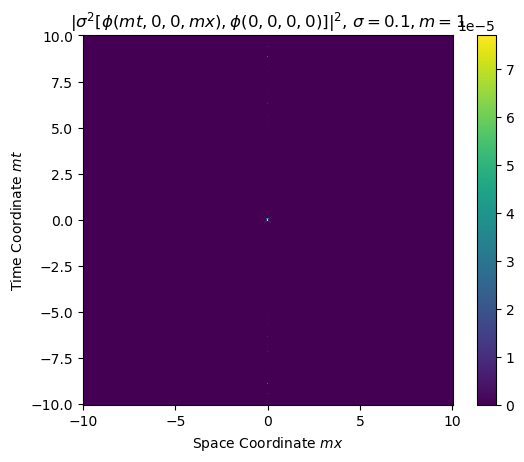

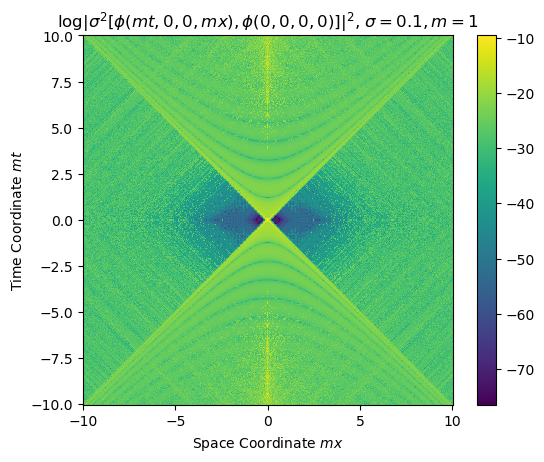

In [42]:
#run1(a, b, num_bins, \sigma, m)
run1(10, 10, 500, .1, 1, log=True)